In [35]:
from typing import TypedDict,Literal, List
from langgraph.graph import StateGraph,START,END

In [36]:
class AgentClass(TypedDict):
    num1: int
    num2: int
    op1: Literal['*','+']
    num3: int
    num4: int
    op2: Literal['*','+']
    res1: int
    res2: int


In [37]:
def add(state: AgentClass) -> AgentClass:
    state['res1']=f"add: {state['num1']} + {state['num2']} = {state['num1']+state['num2']}"
    return state

def sub(state: AgentClass) -> AgentClass:
    state['res1'] = f"sub: {state['num1']} - {state['num2']} = {state['num1']- state['num2']}"

def router(state: AgentClass) -> str:
    if state['op1'] == '+':
        return 'add_op'
    else: 
        return 'sub_op'
    
def add2(state: AgentClass) -> AgentClass:
    state['res2']=f"add2: {state['num3']} + {state['num4']} = {state['num3']+state['num4']}"
    return state

def sub2(state: AgentClass) -> AgentClass:
    state['res2'] = f"sub2: {state['num3']} - {state['num4']} = {state['num3']- state['num4']}"
    return state

def router2(state: AgentClass) -> str:
    if state['op2'] == '+':
        return 'add_op2'
    else: 
        return 'sub_op2'
    

In [38]:
graph = StateGraph(AgentClass)

In [39]:
graph.add_node('addition_node',add)
graph.add_node('addition_node2',add2)
graph.add_node('substract_node',sub)
graph.add_node('substract_node2',sub2)
graph.add_node('router',lambda state:state)
graph.add_node('router2',lambda state:state)
graph.add_edge(START,'router')

graph.add_conditional_edges(
    'router',
    router,
    {
        "add_op":"addition_node",
        "sub_op":"substract_node"
    }
)
graph.add_edge('addition_node','router2')
graph.add_edge('substract_node','router2')

graph.add_conditional_edges(
    'router2',
    router2,
    {
        "add_op2":"addition_node2",
        "sub_op2":"substract_node2"
    }
)
graph.add_edge("addition_node2",END)
graph.add_edge("substract_node2",END)

app = graph.compile()


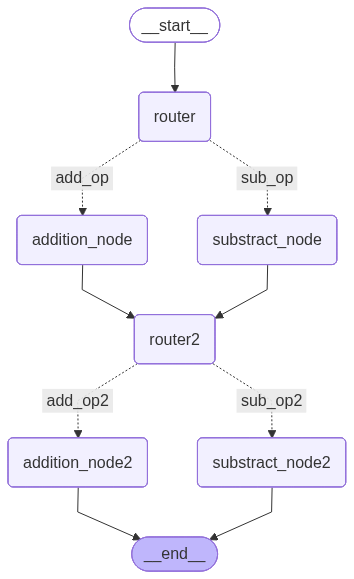

In [40]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [41]:
init = AgentClass(num1=10,num2=20,op1='+',num3=30,num4=10,op2='-')
result = app.invoke(init)

In [42]:
print(result)

{'num1': 10, 'num2': 20, 'op1': '+', 'num3': 30, 'num4': 10, 'op2': '-', 'res1': 'add: 10 + 20 = 30', 'res2': 'sub2: 30 - 10 = 20'}


### Graph with loops
- looping to route flow of data
- must have a conditional edge to handle decision-making

In [43]:
class AgentClass(TypedDict):
    name: str
    number: List[int]
    counter: int

In [44]:
def greet(state: AgentClass) -> AgentClass:
    """Greets the user"""
    state['name']=f"Hi there! {state['name']}"
    state['counter']=0
    return state

def random_node(state: AgentClass)-> AgentClass:
    """Generate random nums 0-10"""
    import random
    state['number'].append(random.randint(0,10))
    state['counter'] += 1
    return state

def should_cont(state: AgentClass)-> AgentClass:
    """funciton to decide what to do next"""
    if state['counter'] < 5:
        return "loop"
    else:
        return "exit"

In [45]:
graph = StateGraph(AgentClass)
graph.add_node('greeting_node',greet)
graph.add_node('random_node',random_node)
graph.add_edge('greeting_node','random_node')
graph.add_conditional_edges(
    'random_node', #source
    should_cont, #action
    {
        "loop" : 'random_node',
        "exit": END
    }
)
graph.set_entry_point('greeting_node')

In [46]:
app = graph.compile()

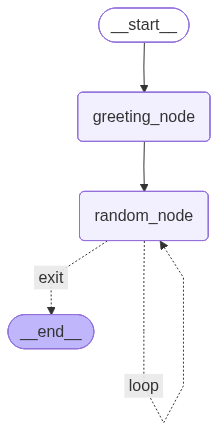

In [47]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [48]:
result =app.invoke(AgentClass(name='Samannway',number=[],counter=-1))

In [49]:
print(result)

{'name': 'Hi there! Samannway', 'number': [10, 10, 3, 1, 9], 'counter': 5}


#### Guessing game with graph nodes
- guess a number betwee high and low
- use random.radint() with high and low to guess
- if guess is lower, say higher: increase low by 1
- if guess is higher, say lower: decrease high by 1
- count attempts

In [50]:
from typing import TypedDict,Literal, List
from langgraph.graph import StateGraph,START,END
class AgentClass(TypedDict):
    actualNum: int
    guess: int
    low: int
    high: int
    res: str
    count: int

In [51]:
def startup(state: AgentClass) -> AgentClass:
    state['count']=0
    import random
    state['guess'] = random.randint(state['low'], state['high'])
    return state
def guess(state: AgentClass) -> AgentClass:
    state['count'] += 1
    import random
    state['guess'] = random.randint(state['low'],state['high'])
    return state
def hint(state: AgentClass)-> str:
    if state['guess'] < state['actualNum']:
        state['low'] = state['guess'] + 1
    elif state['guess'] > state['actualNum']:
        state['high'] = state['guess'] -1
    else:
        state['res']=f"Correct! Guessed at attemp{state['count']}"
    return state
def evaluate(state: AgentClass) -> AgentClass:
    if state['guess'] == state['actualNum']:
        return 'end'
    else:
        return 'continue'
    


In [52]:
graph= StateGraph(AgentClass)
graph.add_node('setup',startup)
graph.add_node('guess',guess)
graph.add_node('hint_node',hint)

graph.add_edge('setup','guess')
graph.add_edge('guess','hint_node')
graph.add_conditional_edges(
    'hint_node',
    evaluate,
    {
        'continue':'guess',
        'end': END
    }
)
graph.set_entry_point('setup')
app=graph.compile()

In [55]:
result=app.invoke(AgentClass(actualNum=5,guess=0,low=0,high=10,count=0))

In [56]:
print(result)

{'actualNum': 5, 'guess': 5, 'low': 5, 'high': 5, 'res': 'Correct! Guessed at attemp4', 'count': 4}
